# Using LLMs to estimate "readability"

*Author: Sean Trott*

In this notebook, I set up and run code to use GPT-4, an LLM, to measure the readability of different text excerpts from the CLEAR corpus.


## Setup

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from nltk import word_tokenize, sent_tokenize

### Seaborn theme
sns.set_theme(style="white", palette='crest')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [2]:
### Styling
# Get the Mako palette
palette = sns.color_palette("mako", 3)

# Select colors from opposite ends
color1 = palette[0]  # First color
color2 = palette[-1] # Last color
color3 = palette[3 // 2]

### Load CLEAR corpus

In [3]:
df = pd.read_csv("../data/raw/CLEAR_corpus_final.csv")
df.shape

(4724, 28)

### Set up GPT

In [4]:
from openai import OpenAI
import openai
client = OpenAI()

## Using GPT

### Helper functions

In [10]:
import backoff 
# for exponential backoff

In [11]:
@backoff.on_exception(backoff.expo, openai.RateLimitError)
def pred_tokens(prompt, system_prompt, n=10, model="gpt-4", temperature = 0):
    """Get response."""
    completion = client.chat.completions.create(
      model=model,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
      ],
        n = n,
        temperature = temperature
    )

    return completion# output['choices'][0]['message']['content']

### Method: Original Readability Measure

In this analysis, I give a general description of readability, and ask GPT-4 to produce a readability score. This is an example of "prompt engineering"; note that I did not make much effort to explore the space of prompts, so this should generally be considered a "local optimum" of what you could achieve using GPT-4.

In [8]:
### Format prompt with text. 
def format_prompt(instructions, text):
    final = instructions + "\n\n<Text>:{text}</Text>\n\nOn a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand), how readable is this text?. Please answer with a single number.".format(text = text)
    return final

In [9]:
### Set up system prompt and isntructions
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts."
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity."


In [10]:
### Subset based on existing file
INDEX = 0
df_subset = df[INDEX:len(df)]
df_subset.shape

(4724, 28)

In [88]:
### Set up parameters
MODEL = "gpt-4-1106-preview"

### Open output .txt file
OUTPUT_PATH = "../data/processed/readability_basic_{m}.txt".format(m=MODEL)

In [89]:
results = []

df_subset = df[INDEX:len(df)]
for index, row in tqdm(df.iterrows(), total = len(df)):
    
    excerpt = row['Excerpt']
    
    ### Format using prompt
    prompt = format_prompt(instructions, excerpt)
    
    ### Obtain completion, allowing for backoff
    completion = pred_tokens(prompt = prompt, 
                             system_prompt = system_prompt,
                            n = 3,
                            model = MODEL)
    
    ### Replace newline characters to avoid text processing issues later
    text_modified = excerpt.replace('\n', '\\n')
    
    ### Write output to output file
    with open(OUTPUT_PATH, "a") as f:
        f.write("{excerpt}\t{response}\n".format(excerpt = text_modified, 
                                                response = completion.choices[0].message.content))
    
    ### Also track in DataFrame
    results.append({
        'Excerpt': excerpt,
        'GPT_Response': completion.choices[0].message.content
    })
    

100%|█████████████████████████████████████| 4724/4724 [2:48:55<00:00,  2.15s/it]


In [90]:
df_results = pd.DataFrame(results)

In [92]:
df_results.to_csv("../data/processed/readability_basic_{m}.csv".format(m=MODEL), index=False)

In [11]:
### Set up parameters
MODEL = "gpt-4o-mini-2024-07-18"
print(MODEL)

### Open output .txt file
OUTPUT_PATH = "../data/processed/readability_basic_{m}.txt".format(m=MODEL)

In [12]:
results = []

print(MODEL)

df_subset = df[INDEX:len(df)]
for index, row in tqdm(df.iterrows(), total = len(df)):
    
    excerpt = row['Excerpt']
    
    ### Format using prompt
    prompt = format_prompt(instructions, excerpt)
    
    ### Obtain completion, allowing for backoff
    completion = pred_tokens(prompt = prompt, 
                             system_prompt = system_prompt,
                            n = 3,
                            model = MODEL)
    
    ### Replace newline characters to avoid text processing issues later
    text_modified = excerpt.replace('\n', '\\n')
    
    ### Write output to output file
    with open(OUTPUT_PATH, "a") as f:
        f.write("{excerpt}\t{response}\n".format(excerpt = text_modified, 
                                                response = completion.choices[0].message.content))
    
    ### Also track in DataFrame
    results.append({
        'Excerpt': excerpt,
        'GPT_Response': completion.choices[0].message.content
    })
    

gpt-4o-mini-2024-07-18


100%|███████████████████████████████████████| 4724/4724 [42:08<00:00,  1.87it/s]


In [13]:
df_results = pd.DataFrame(results)

In [14]:
MODEL

'gpt-4o-mini-2024-07-18'

In [15]:
df_results.to_csv("../data/processed/readability_basic_{m}.csv".format(m=MODEL), index=False)

## Results

In [6]:
### Helper functions
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_number(ans):
    """Retrieves number from GPT-4 response."""
    if type(ans) is int:
        return ans
    res = [float(i) for i in ans.split() if is_number(i)]
    if len(res) == 0:
        return None
    return res[0]

### Turbo

Now, we ask how well GPT-4's readability measure predicts our gold standard: `BT_easiness`. We compare this to the other formulaic measures included in the dataset, and also to the split-reliability measure reported in the text.

#### Load and process data

In [7]:
### Load .csv
df_results = pd.read_csv("../data/processed/readability_basic_gpt-4-1106-preview.csv")
df_results.shape

(4724, 2)

In [8]:
### Process numeric results
df_results['GPT_rating'] = df_results['GPT_Response'].apply(lambda x: get_number(x))
df_results['GPT_rating'].mean()

70.56731583403895

In [9]:
### Merge with original Dataframe
df_merged = pd.merge(df_results, df)
df_merged.shape

(4724, 30)

### 4o mini

#### Load and process data

In [10]:
### Load .csv
df_results = pd.read_csv("../data/processed/readability_basic_gpt-4o-mini-2024-07-18.csv")
df_results.shape

(4724, 2)

In [11]:
### Process numeric results
df_results['GPT_4o_rating'] = df_results['GPT_Response'].apply(lambda x: get_number(x))
df_results['GPT_4o_rating'].mean()

70.55673158340389

In [12]:
df_results = df_results[['Excerpt', 'GPT_4o_rating']]

In [13]:
### Merge with original Dataframe
df_merged = pd.merge(df_results, df_merged)
df_merged.shape

(4724, 31)

#### Descriptive statistics

In [14]:
df_merged['GPT_rating'].describe()

count    4724.000000
mean       70.567316
std        16.725857
min        20.000000
25%        60.000000
50%        75.000000
75%        85.000000
max       100.000000
Name: GPT_rating, dtype: float64

In [15]:
df_merged['GPT_4o_rating'].describe()

count    4724.000000
mean       70.556732
std        14.343461
min        25.000000
25%        65.000000
50%        65.000000
75%        85.000000
max        95.000000
Name: GPT_4o_rating, dtype: float64

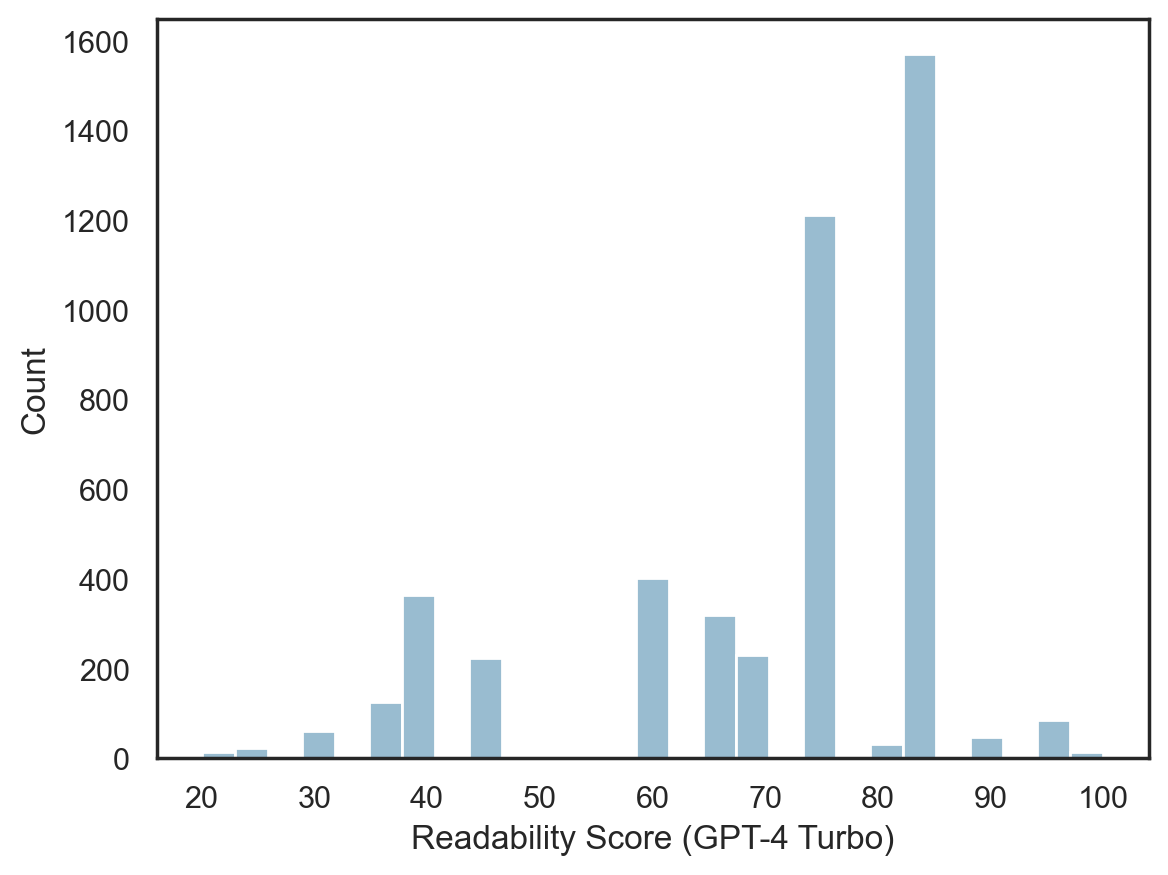

In [16]:
sns.histplot(data = df_merged, x = 'GPT_rating', alpha = .5, color = color3)
plt.xlabel("Readability Score (GPT-4 Turbo)")
plt.savefig("Figures/gpt4_scores.png", dpi = 300)

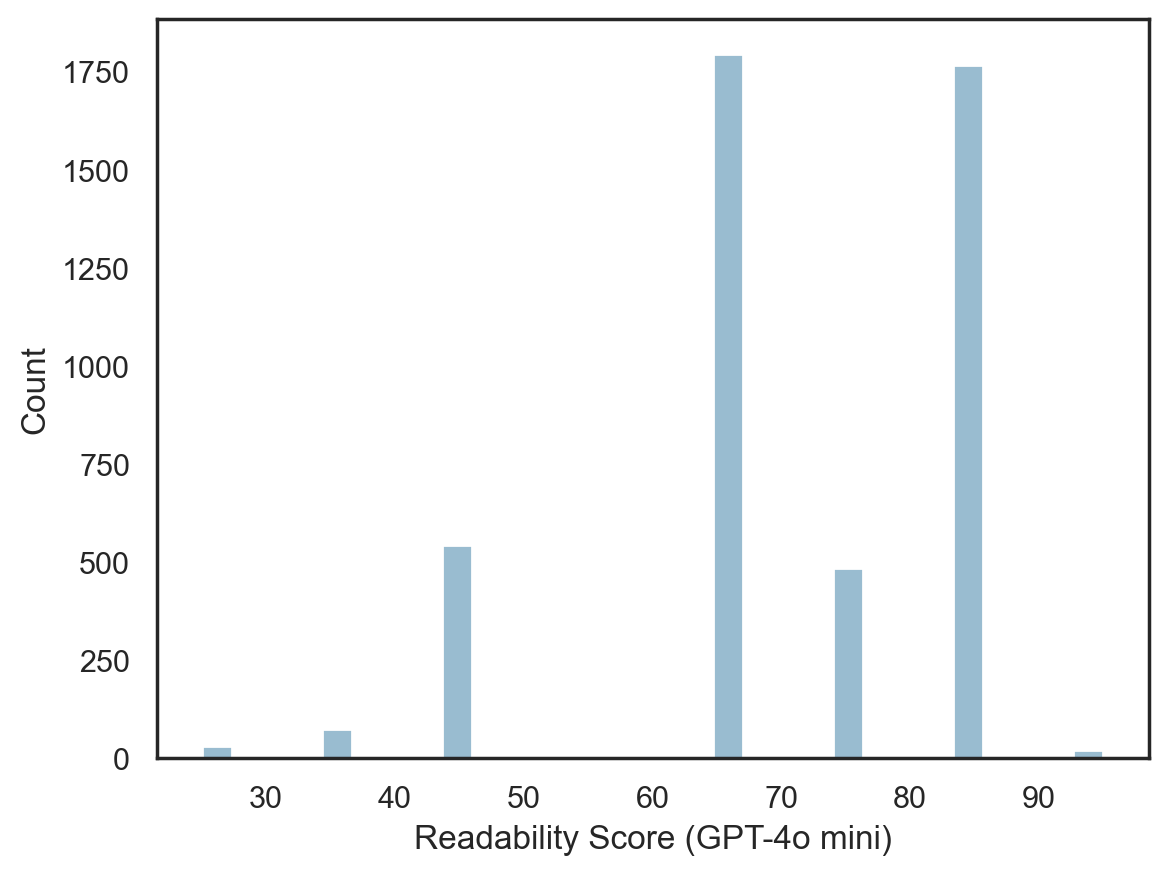

In [17]:
sns.histplot(data = df_merged, x = 'GPT_4o_rating', alpha = .5, color = color3)
plt.xlabel("Readability Score (GPT-4o mini)")
plt.savefig("Figures/gpt4o-mini_scores.png", dpi = 300)

In [18]:
mod = smf.ols(data = df_merged, formula = "BT_easiness ~ GPT_4o_rating").fit()
mod.params

Intercept       -4.724112
GPT_4o_rating    0.053382
dtype: float64

In [19]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            BT_easiness   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     5741.
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:18:37   Log-Likelihood:                -4979.6
No. Observations:                4724   AIC:                             9963.
Df Residuals:                    4722   BIC:                             9976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.7241      0.051    -93.134      0.000      -4.824      -4.625
GPT_4o_rating     0.0534      0.001     75.773      0.000       0.052       0.055
==============================================================================
Omnibus:                        2.806   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                2.750
Skew:                          -0.055   Prob(JB):                        0.253
Kurtosis:                       3.042   Cond. No.                         362.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
mod = smf.ols(data = df_merged, formula = "BT_easiness ~ GPT_rating").fit()
mod.params

Intercept    -4.285327
GPT_rating    0.047156
dtype: float64

In [21]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            BT_easiness   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     6581.
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:18:39   Log-Likelihood:                -4797.3
No. Observations:                4724   AIC:                             9599.
Df Residuals:                    4722   BIC:                             9611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2853      0.042   -101.654      0.000      -4.368      -4.203
GPT_rating     0.0472      0.001     81.124      0.000       0.046       0.048
==============================================================================
Omnibus:                        2.849   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.879
Skew:                          -0.050   Prob(JB):                        0.237
Kurtosis:                       2.933   Cond. No.                         315.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

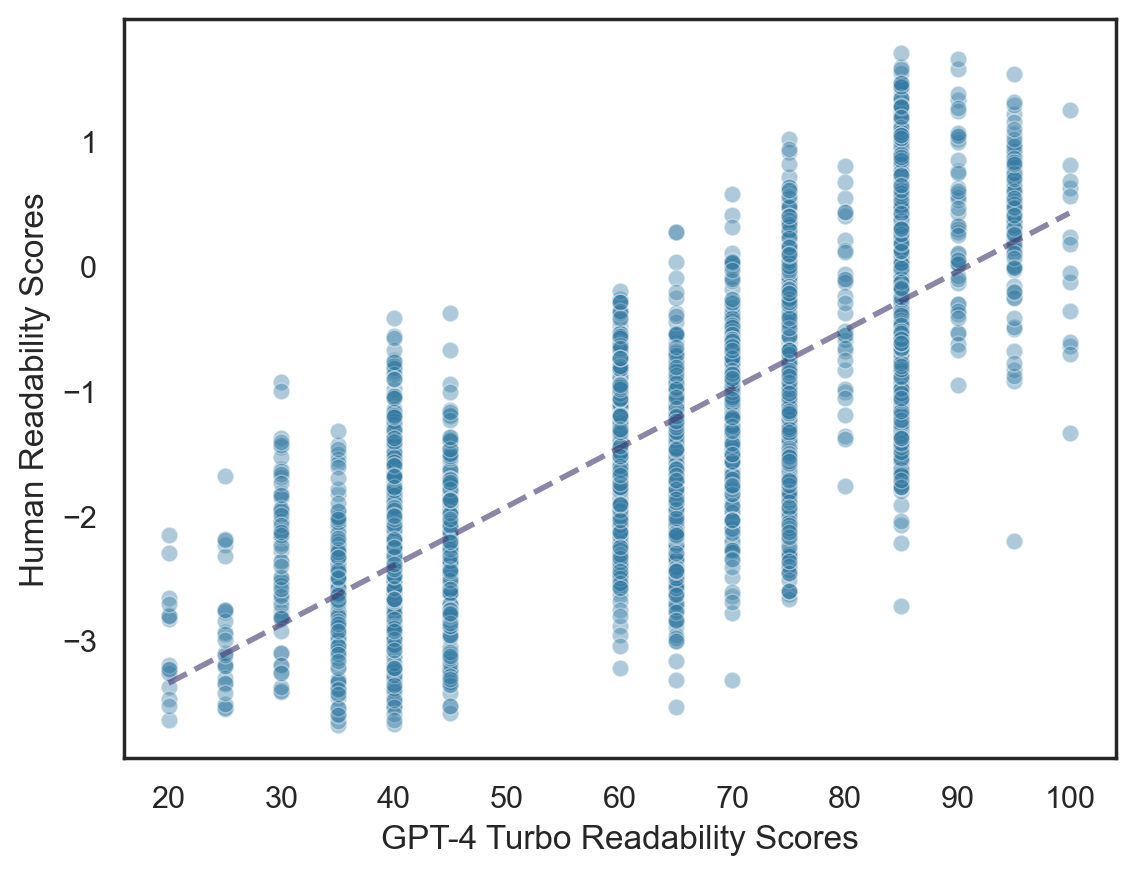

In [22]:
### GPT-4 vs. human readability scores
sns.scatterplot(data = df_merged, x = "GPT_rating", y = "BT_easiness", color = color3, alpha = .4)
plt.xlabel("GPT-4 Turbo Readability Scores")
plt.ylabel("Human Readability Scores")

### Plot predicitons
x = np.arange(20, 100, step = .1)
y = mod.params['Intercept'] + mod.params['GPT_rating'] * x
plt.plot(x, y, color = color1, linestyle = "dashed", alpha = .6, linewidth = 2)

plt.savefig("Figures/gpt_human.png", dpi = 300)

### Intrinsic dimensionality

In [23]:
df_id = pd.read_csv("../data/processed/intrinsic_dim/readability_id_model-roberta-base.csv")
df_id.head(3)                 

,Model_name,Layer,Intrinsic_dim,Excerpt
0,roberta-base,0,107,When the young people returned to the ballroom...
1,roberta-base,1,113,When the young people returned to the ballroom...
2,roberta-base,2,122,When the young people returned to the ballroom...


<Axes: xlabel='Layer', ylabel='Intrinsic_dim'>

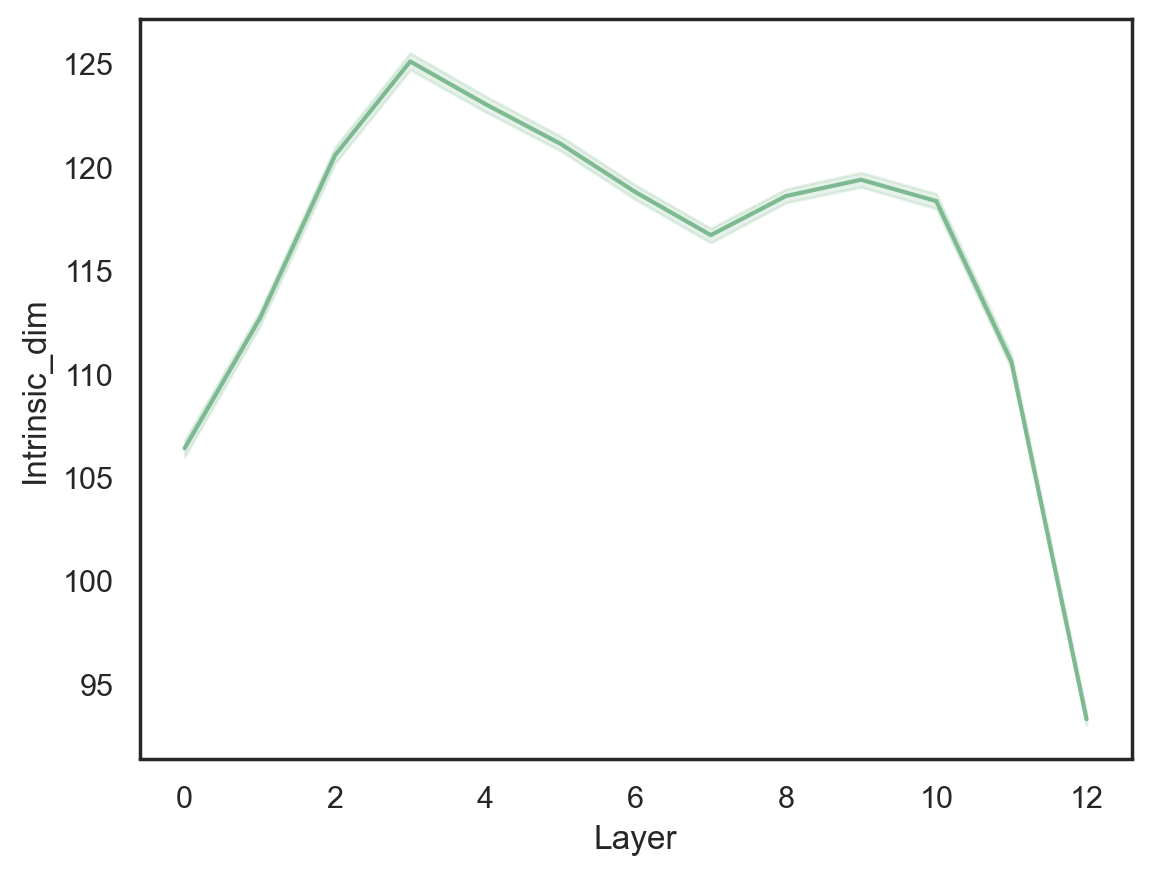

In [24]:
sns.lineplot(data = df_id, x = "Layer", y = "Intrinsic_dim")

In [25]:
df_with_id = pd.merge(df, df_id)
df_with_id.shape

(61412, 31)

#### $R^2$ by layer

In [26]:
res = []
for i in range(0, max(df_with_id['Layer']+1)):
    mod = smf.ols(data = df_with_id[df_with_id['Layer']==i], formula = "BT_easiness ~ Intrinsic_dim").fit()
    res.append({
    'Layer': i,
    'R2': mod.rsquared})
df_res = pd.DataFrame(res)

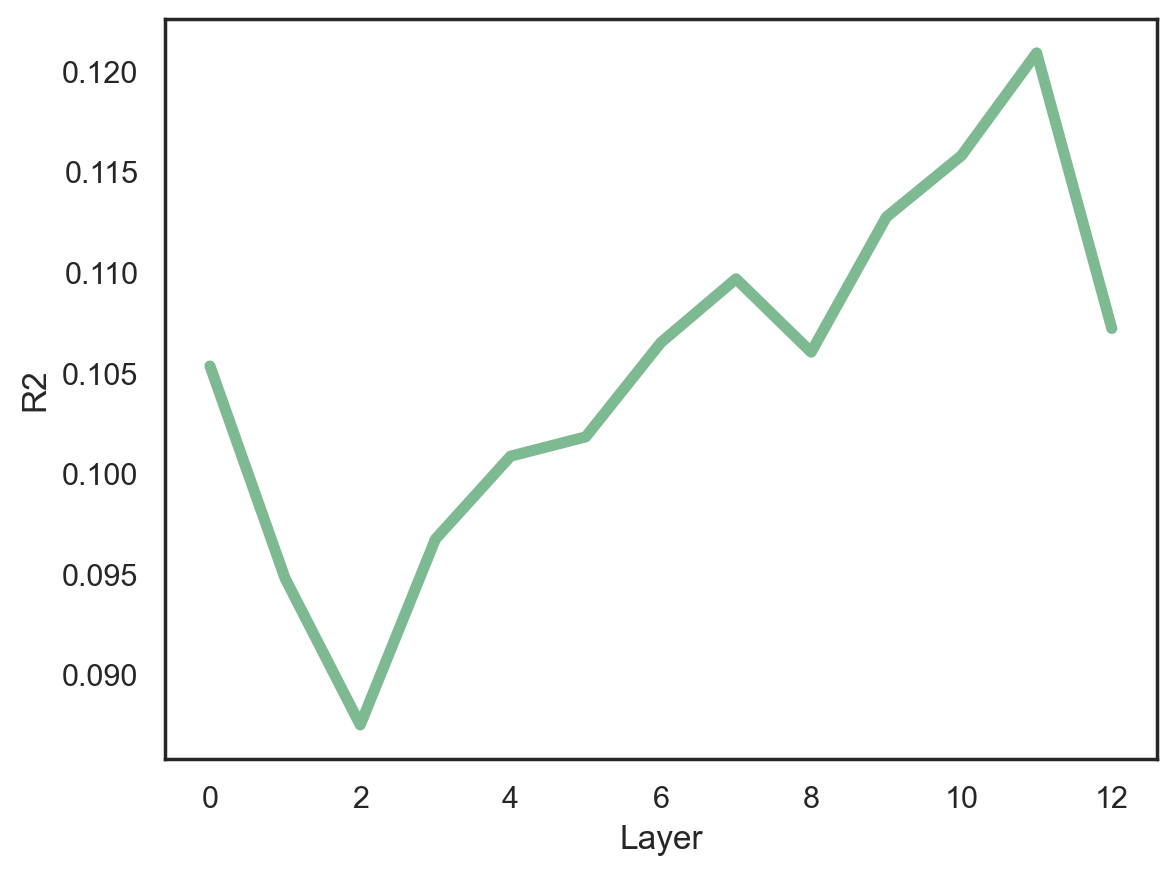

In [27]:
sns.lineplot(data = df_res, x = "Layer", y = "R2", linewidth = 4)

plt.savefig("Figures/r2_intrinsic_dim.png", dpi = 300)

In [28]:
df_res['R2'].describe()

count    13.000000
mean      0.105073
std       0.008969
min       0.087509
25%       0.100863
50%       0.106034
75%       0.109677
max       0.120903
Name: R2, dtype: float64

#### Select best layer

In [29]:
df_id_best = df_id[df_id['Layer'] == 11]
df_id_best.shape

(4724, 4)

In [30]:
df_merged = pd.merge(df_id_best, df_merged)
df_merged.shape

(4724, 34)

### Check psycholinguistic variables

#### Load data

In [31]:
df_aoa = pd.read_csv("../data/lexical_statistics/AoA.csv")
df_aoa.head(2)

,word,OccurTotal,OccurNum,Freq_pm,AoA,AoA_SD,Dunno
0,a,22,22,20415.27,2.89,1.21,1.0
1,aardvark,18,18,0.41,9.89,3.66,1.0


In [32]:
df_conc = pd.read_csv("../data/lexical_statistics/concreteness.csv")
df_conc['log_freq'] = np.log10(df_conc['SUBTLEX'] + 1)
df_conc.head(2)

,word,Bigram,Concreteness,Concreteness_SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos,log_freq
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0,0.0
1,traindriver,0,4.54,0.71,3,29,0.90,0,0,0.0


In [33]:
word_to_aoa = dict(zip(df_aoa['word'], df_aoa['AoA']))
word_to_conc = dict(zip(df_conc['word'], df_conc['Concreteness']))
word_to_lf = dict(zip(df_conc['word'], df_conc['log_freq']))

#### Helper function

In [34]:
def avg_lexical_statistic(text, mapping):
    """Calculates avg AoA/conc/frequency of words in a text."""
    # Convert the text to lowercase to match the case of dictionary keys
    text = text.lower()
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # List to hold the AoA of words found in the dictionary
    aoas = []
    
    # Check each word against the dictionary
    for word in words:
        if word in mapping:
            aoas.append(mapping[word])
    
    # Calculate the average AoA if there are any valid AoA values
    if aoas:
        avg_aoa = sum(aoas) / len(aoas)
    else:
        avg_aoa = 0  # Return 0 or an appropriate value if no words match
    
    return avg_aoa

#### Calculate

In [35]:
df_merged['avg_aoa'] = df_merged['Excerpt'].apply(lambda x: avg_lexical_statistic(x, word_to_aoa))
df_merged['avg_conc'] = df_merged['Excerpt'].apply(lambda x: avg_lexical_statistic(x, word_to_conc))
df_merged['avg_lf'] = df_merged['Excerpt'].apply(lambda x: avg_lexical_statistic(x, word_to_lf))

#### Regression

In [36]:
mod_pl = smf.ols(data = df_merged, formula = "BT_easiness ~ avg_aoa + avg_conc + avg_lf").fit()
mod_pl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            BT_easiness   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     884.2
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:19:00   Log-Likelihood:                -5805.6
No. Observations:                4724   AIC:                         1.162e+04
Df Residuals:                    4720   BIC:                         1.165e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2980      1.062     -5.928      0.000      -8.381      -4.215
avg_aoa       -0.5565      0.056     -9.874      0.000      -0.667      -0.446
avg_conc       1.7593      0.106     16.594      0.000       1.551       1.967
avg_lf         0.8232      0.127      6.479      0.000       0.574       1.072
==============================================================================
Omnibus:                        7.227   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                6.754
Skew:                          -0.058   Prob(JB):                       0.0341
Kurtosis:                       2.855   Cond. No.                         669.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Regression

In [37]:
mod_pl = smf.ols(data = df_merged, formula = "GPT_rating ~ avg_aoa + avg_conc + avg_lf").fit()
mod_pl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             GPT_rating   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     980.8
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:19:00   Log-Likelihood:                -18865.
No. Observations:                4724   AIC:                         3.774e+04
Df Residuals:                    4720   BIC:                         3.776e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.0169     16.862     -1.424      0.154     -57.075       9.041
avg_aoa       -8.8864      0.895     -9.933      0.000     -10.640      -7.133
avg_conc      31.0882      1.683     18.474      0.000      27.789      34.387
avg_lf        13.5213      2.017      6.705      0.000       9.568      17.475
==============================================================================
Omnibus:                      258.063   Durbin-Watson:                   1.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.391
Skew:                          -0.595   Prob(JB):                     3.58e-66
Kurtosis:                       3.336   Cond. No.                         669.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Correlation matrix

In [38]:
ss.pearsonr(df_merged['BT_easiness'], df_merged['GPT_rating'])

PearsonRResult(statistic=0.7630469009198535, pvalue=0.0)

In [39]:
ss.pearsonr(df_merged['BT_easiness'], df_merged['GPT_4o_rating'])

PearsonRResult(statistic=0.740754305751743, pvalue=0.0)

In [40]:
ss.pearsonr(df_merged['GPT_rating'], df_merged['GPT_4o_rating'])

PearsonRResult(statistic=0.8138512374585739, pvalue=0.0)

In [41]:
df_merged['Turbo_rating'] = df_merged['GPT_rating']
df_merged['4o_rating'] = df_merged['GPT_4o_rating']

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:262: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


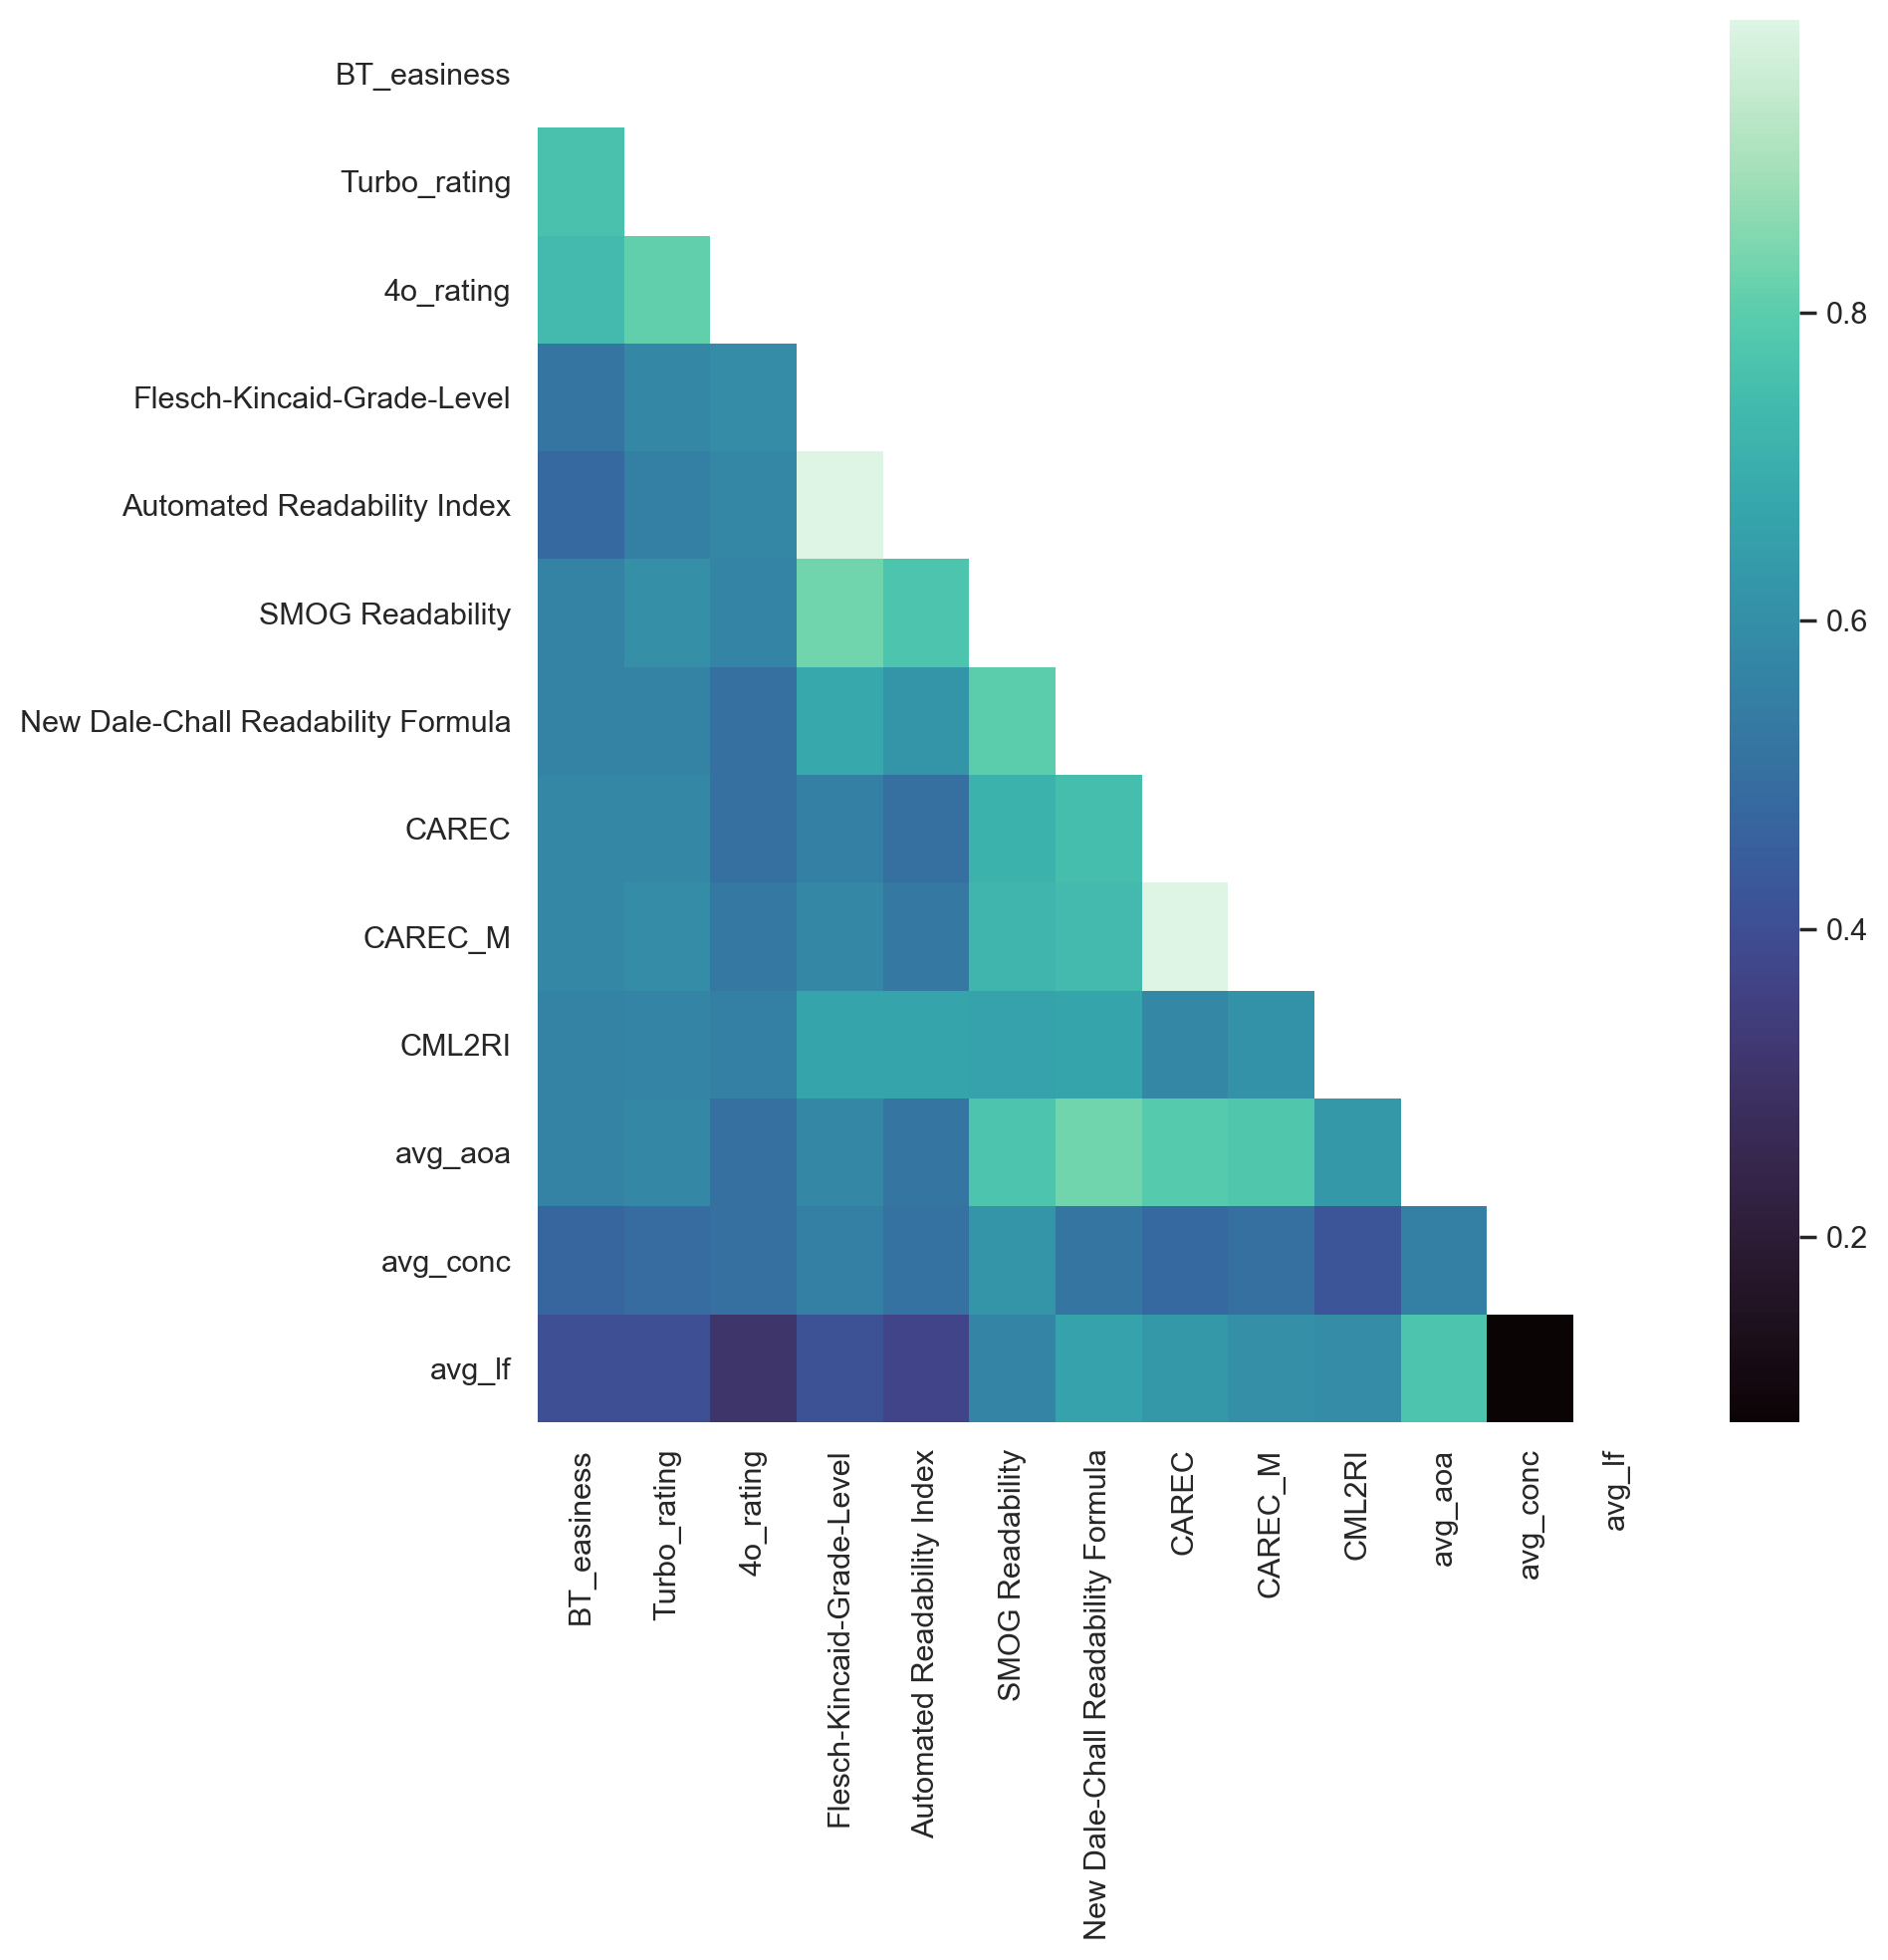

In [42]:
### Now, create a correlation matrix

df_subset = df_merged[[ 'BT_easiness', 'Turbo_rating', '4o_rating','Flesch-Kincaid-Grade-Level', 'Automated Readability Index',
               'SMOG Readability', 'New Dale-Chall Readability Formula', 'CAREC', 'CAREC_M', 'CML2RI',
                      'avg_aoa', 'avg_conc', 'avg_lf']]
correlation_matrix = round(df_subset.corr(), 2)
plt.figure(figsize=(10, 10))

### Mask lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
### Now plot using heatmap
sns.heatmap(np.abs(correlation_matrix), annot=True, cmap='mako', mask=mask)
plt.tight_layout()

plt.savefig("Figures/matrix.png", dpi = 300)

## Show
plt.show()



In [43]:
correlation_matrix

,BT_easiness,Turbo_rating,4o_rating,Flesch-Kincaid-Grade-Level,Automated Readability Index,SMOG Readability,New Dale-Chall Readability Formula,CAREC,CAREC_M,CML2RI,avg_aoa,avg_conc,avg_lf
BT_easiness,1.00,0.76,0.74,-0.52,-0.48,-0.56,-0.56,-0.58,-0.58,0.56,-0.56,0.47,0.40
Turbo_rating,0.76,1.00,0.81,-0.58,-0.55,-0.60,-0.56,-0.58,-0.59,0.57,-0.58,0.49,0.40
4o_rating,0.74,0.81,1.00,-0.59,-0.58,-0.57,-0.50,-0.50,-0.53,0.55,-0.50,0.50,0.31
Flesch-Kincaid-Grade-Level,-0.52,-0.58,-0.59,1.00,0.99,0.83,0.68,0.55,0.58,-0.67,0.58,-0.55,-0.41
Automated Readability Index,-0.48,-0.55,-0.58,0.99,1.00,0.77,0.62,0.50,0.53,-0.67,0.52,-0.51,-0.37
SMOG Readability,-0.56,-0.60,-0.57,0.83,0.77,1.00,0.80,0.71,0.72,-0.66,0.77,-0.62,-0.57
New Dale-Chall Readability Formula,-0.56,-0.56,-0.50,0.68,0.62,0.80,1.00,0.75,0.74,-0.67,0.83,-0.52,-0.66
CAREC,-0.58,-0.58,-0.50,0.55,0.50,0.71,0.75,1.00,0.99,-0.58,0.79,-0.48,-0.63
CAREC_M,-0.58,-0.59,-0.53,0.58,0.53,0.72,0.74,0.99,1.00,-0.61,0.78,-0.50,-0.60
CML2RI,0.56,0.57,0.55,-0.67,-0.67,-0.66,-0.67,-0.58,-0.61,1.00,-0.63,0.42,0.59


### Statistical modeling

Now, we build a linear model predicting `BT_easiness` from a range of factors available in the dataset.

In [44]:
## Rename some variables for ease
df_merged['Word_count'] = df_merged['Google WC']
df_merged['Flesch'] = df_merged['Flesch-Reading-Ease']
df_merged['Sentence_count'] = df_merged['Sentence Count']
df_merged['ARI'] = df_merged['Automated Readability Index']
df_merged['SMOG'] = df_merged['SMOG Readability']
df_merged['NDC'] = df_merged['New Dale-Chall Readability Formula']

## Turn Category into a numeric variable
df_merged['Categ_numeric'] = df_merged['Categ'].apply(lambda x: 1 if x == 'Lit' else 0)

In [45]:
## Define features
features = ['Categ_numeric', 'Turbo_rating', '4o_rating', 'Paragraphs', 'Word_count', 
            "Sentence_count", "Flesch-Reading-Ease", "ARI", "SMOG", 
            "NDC", "CAREC_M", "CML2RI", 'avg_aoa', 'avg_conc', 'avg_lf']

# Get predictors and target
predictors = df_merged[features]  
target = df_merged['BT_easiness']

# Standardize the predictors
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

# Add intercept
predictors_scaled = sm.add_constant(predictors_scaled)

# Fit the OLS model
model = sm.OLS(target, predictors_scaled).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            BT_easiness   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     654.2
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:19:26   Log-Likelihood:                -4198.4
No. Observations:                4724   AIC:                             8429.
Df Residuals:                    4708   BIC:                             8532.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9576      0.009   -111.655      0.0

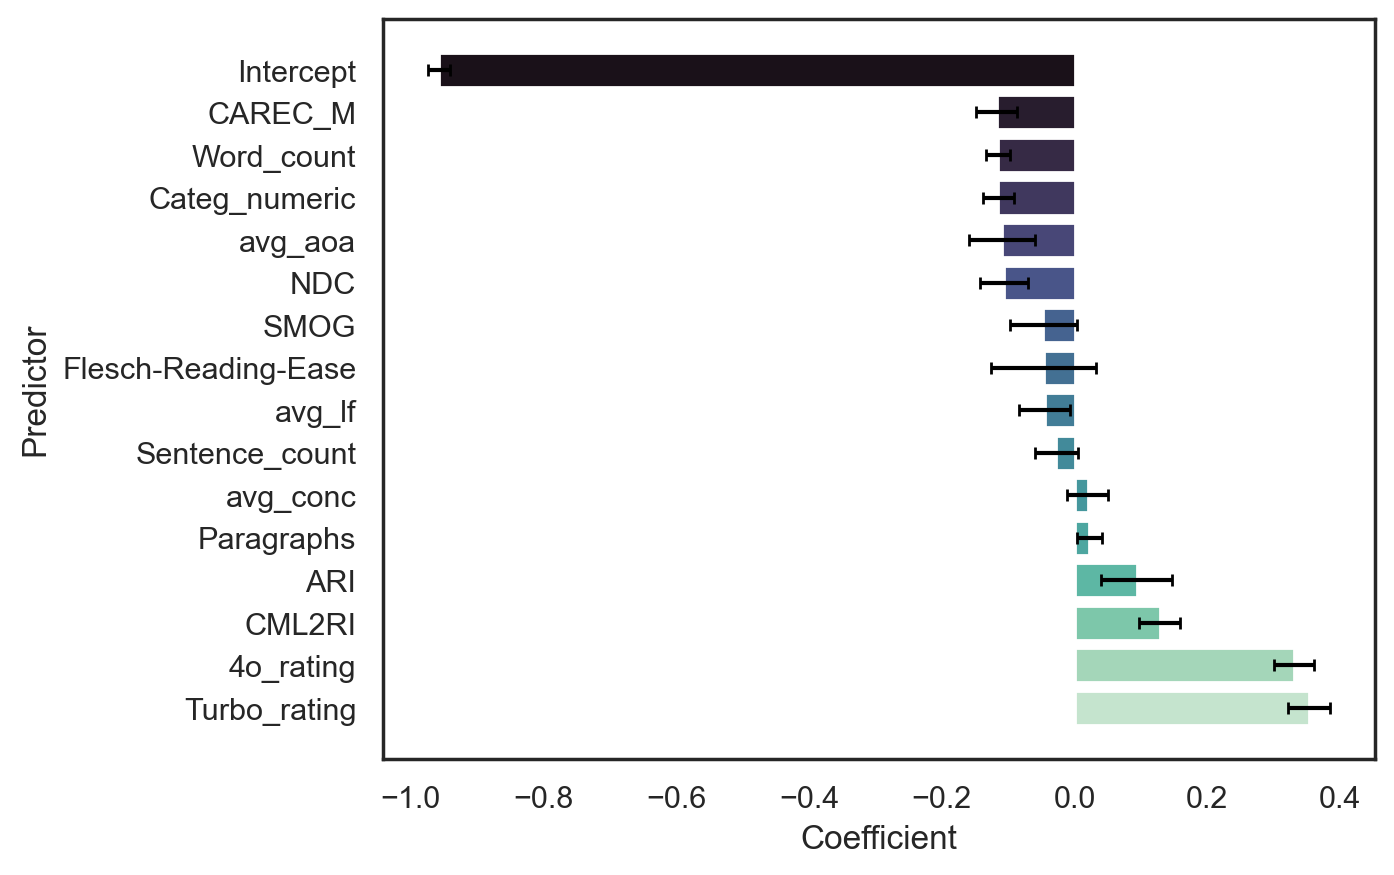

In [46]:
### Visualize coefficients
df_results = pd.DataFrame({
    'Coefficient': model.params,
    'Predictor': ['Intercept'] + features,
    'Standard Error': model.bse
})

df_results['CI'] = df_results['Standard Error'] * 1.96

### Plot results
df_results = df_results.sort_values("Coefficient")
### Pointplot
sns.barplot(data = df_results, y = "Predictor", x = "Coefficient", palette = "mako")
plt.errorbar(y = df_results['Predictor'], x = df_results['Coefficient'],
            xerr=df_results['CI'], fmt='none', c= 'black', capsize = 2)

plt.savefig("Figures/all_coefs.png", dpi = 300)

### Identifying feature importances

Now, we use a few different approaches to ask whether `GPT_rating` is, in fact, a reliably useful feature for predicting `BT_easiness`.

- Feature importance scores for `RandomForestRegressor`.  
- Regularized coefficients using Lasso Regression.

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

##### Random forest regression

In [48]:
# Standardize the predictors
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

### Set up
X = predictors_scaled
y = target

In [49]:
### Fit model, using no constraints on max_depth
clf = RandomForestRegressor(max_depth=None, random_state=0)
clf.fit(X, y)

RandomForestRegressor(random_state=0)

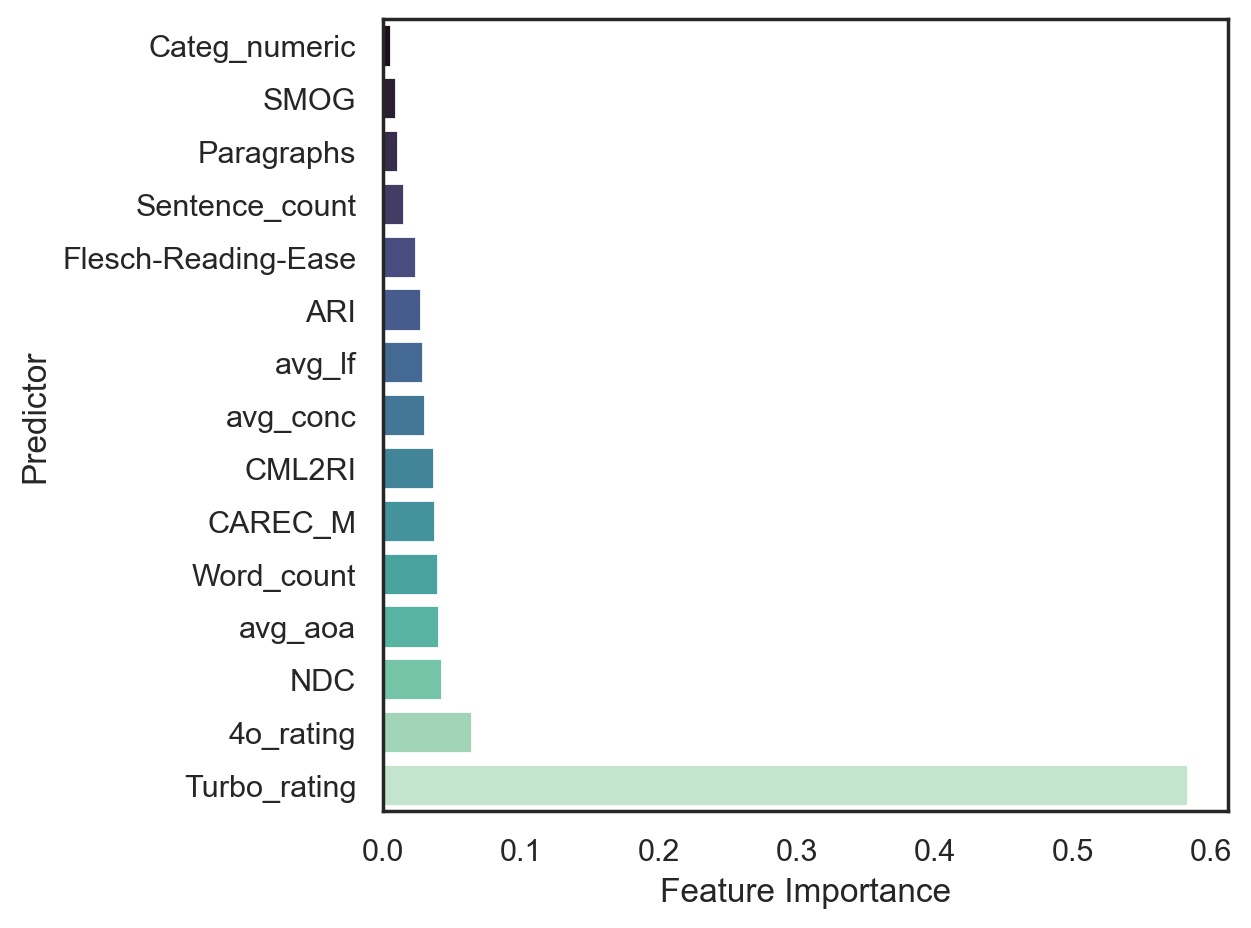

In [50]:
### Visualize coefficients
df_results = pd.DataFrame({
    'Feature Importance': clf.feature_importances_,
    'Predictor': features
})

### Plot results
df_results = df_results.sort_values("Feature Importance")
### Bar plot
sns.barplot(data = df_results, y = "Predictor", x = "Feature Importance", palette = "mako")

##
plt.tight_layout()
plt.savefig("Figures/rf_importance.png", dpi = 300)